# Inference RelateAnything with PSG

In [112]:
%load_ext autoreload
%autoreload 2

from segment_anything import build_sam, SamPredictor, SamAutomaticMaskGenerator
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
predictor = SamPredictor(build_sam(
    checkpoint="segment_anything/sam_vit_h_4b8939.pth"))
mask_generator = SamAutomaticMaskGenerator(build_sam(
    checkpoint="segment_anything/sam_vit_h_4b8939.pth"))

### Some Useful Functions

In [7]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def sort_and_deduplicate(sam_masks, iou_threshold=0.8):
    # Sort the sam_masks list based on the area value
    sorted_masks = sorted(sam_masks, key=lambda x: x['area'], reverse=True)

    # Deduplicate masks based on the given iou_threshold
    filtered_masks = []
    for mask in sorted_masks:
        duplicate = False
        for filtered_mask in filtered_masks:
            if iou(mask['segmentation'], filtered_mask['segmentation']) > iou_threshold:
                duplicate = True
                break

        if not duplicate:
            filtered_masks.append(mask)

    return filtered_masks

In [8]:
import matplotlib.pyplot as plt
def show_anns(anns, color_code='auto'):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        if color_code == 'auto':
            for i in range(3):
                img[:,:,i] = color_mask[i]
        elif color_code == 'red':
            for i in range(3):
                img[:,:,0] = 1
                img[:,:,1] = 0
                img[:,:,2] = 0
        else:
            for i in range(3):
                img[:,:,0] = 0
                img[:,:,1] = 0
                img[:,:,2] = 1
    return np.dstack((img, m*0.35))

In [9]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)   

def show_mask(m):
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        img[:,:,0] = 1
        img[:,:,1] = 0
        img[:,:,2] = 0

    return np.dstack((img, m*0.35))

### Model Loading

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [92]:
# load model
input_size = 512
hidden_size = 256
num_classes = 56
model = MLP(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load("./share/model/best_model_bce.pth"))
# model.load_state_dict(torch.load("best_model_bce_153.pth"))

FileNotFoundError: [Errno 2] No such file or directory: 'best_model_bce_153.pth'

## Demo

In [85]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_name = './images/psg_demo.png'

image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pilimage = Image.open(image_name)
width, height = pilimage.size
full_area = width * height

In [67]:
from pathlib import Path
import matplotlib.pyplot as plt
import pprint

import numpy as np

from openpsg.utils.vis_tools.datasets import coco_dir
from openpsg.utils.vis_tools.preprocess import load_json

from detectron2.data.detection_utils import read_image
from detectron2.utils.colormap import colormap
from panopticapi.utils import rgb2id

def get_colormap(num_colors: int):
    return (np.resize(colormap(), (num_colors, 3))).tolist()

In [68]:
# set working path as home dir to easy access data
psg_dataset_file = load_json(Path("data/psg/psg.json"))
print('keys: ', list(psg_dataset_file.keys()))

psg_thing_cats = psg_dataset_file['thing_classes']
psg_stuff_cats = psg_dataset_file['stuff_classes']
psg_obj_cats = psg_thing_cats + psg_stuff_cats
psg_rel_cats = psg_dataset_file['predicate_classes']
psg_dataset = {d["image_id"]: d for d in psg_dataset_file['data']}
# psg_dataset_coco_id = {d["coco_image_id"]: d for d in psg_dataset_file['data']}

print('Number of images: {}'.format(len(psg_dataset)))
print('# Object Classes: {}'.format(len(psg_obj_cats)))
print('# Relation Classes: {}'.format(len(psg_rel_cats)))

keys:  ['data', 'thing_classes', 'stuff_classes', 'predicate_classes', 'test_image_ids']
Number of images: 48749
# Object Classes: 133
# Relation Classes: 56


In [69]:
example_img_id = '107902'
data = psg_dataset[example_img_id]
image = read_image(coco_dir / data["file_name"], format="RGB")

### Step 1: User click object

In [86]:
predictor.set_image(image)

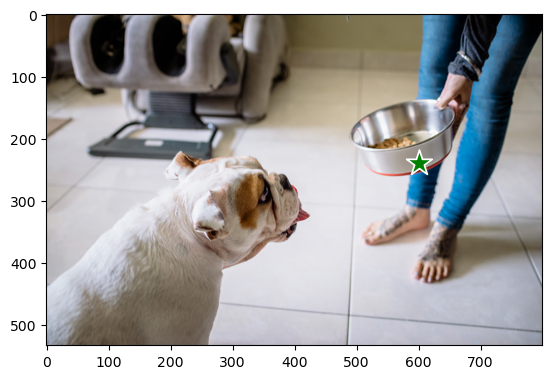

In [108]:
# # dog
# input_point = np.array([[150, 375]])
# input_label = np.array([1])

# # dog
# input_point = np.array([[200, 375]])
# input_label = np.array([1])

# bowl
input_point = np.array([[600, 240]])
input_label = np.array([1])

# # human
# input_point = np.array([[700, 50]])
# input_label = np.array([1])

# ground
# input_point = np.array([[500, 400]])
# input_label = np.array([1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.show()

mask1, score1, logit1, feat1 = predictor.predict(point_coords=input_point,
                                                 point_labels=input_label,
                                                 multimask_output=False,)

### Step 2: Segment Anything

In [89]:
sam_masks = mask_generator.generate(image)

In [110]:
# remove very small items, duplicate items, and itself
filtered_masks = [d for d in sam_masks if iou(d['segmentation'], mask1[0]) < 0.95]
filtered_masks = [d for d in filtered_masks if d['area'] > 0.03 * full_area]
filtered_masks = sort_and_deduplicate(filtered_masks)
print('number of masks left:', len(filtered_masks))

number of masks left: 11


### Step 3: Setup Relations

In [75]:
relation_classes = [
    'over', 'in front of', 'beside', 'on', 'in', 'attached to', 'hanging from', 'on back of', 'falling off', 
    'going down', 'painted on', 'walking on', 'running on', 'crossing', 'standing on', 'lying on', 'sitting on', 
    'flying over', 'jumping over', 'jumping from', 'wearing', 'holding', 'carrying', 'looking at', 'guiding', 
    'kissing', 'eating', 'drinking', 'feeding', 'biting', 'catching', 'picking', 'playing with', 'chasing', 
    'climbing', 'cleaning', 'playing', 'touching', 'pushing', 'pulling', 'opening', 'cooking', 'talking to', 
    'throwing', 'slicing', 'driving', 'riding', 'parked on', 'driving on', 'about to hit', 'kicking', 'swinging', 
    'entering', 'exiting', 'enclosing', 'leaning on']

In [76]:
k = 3

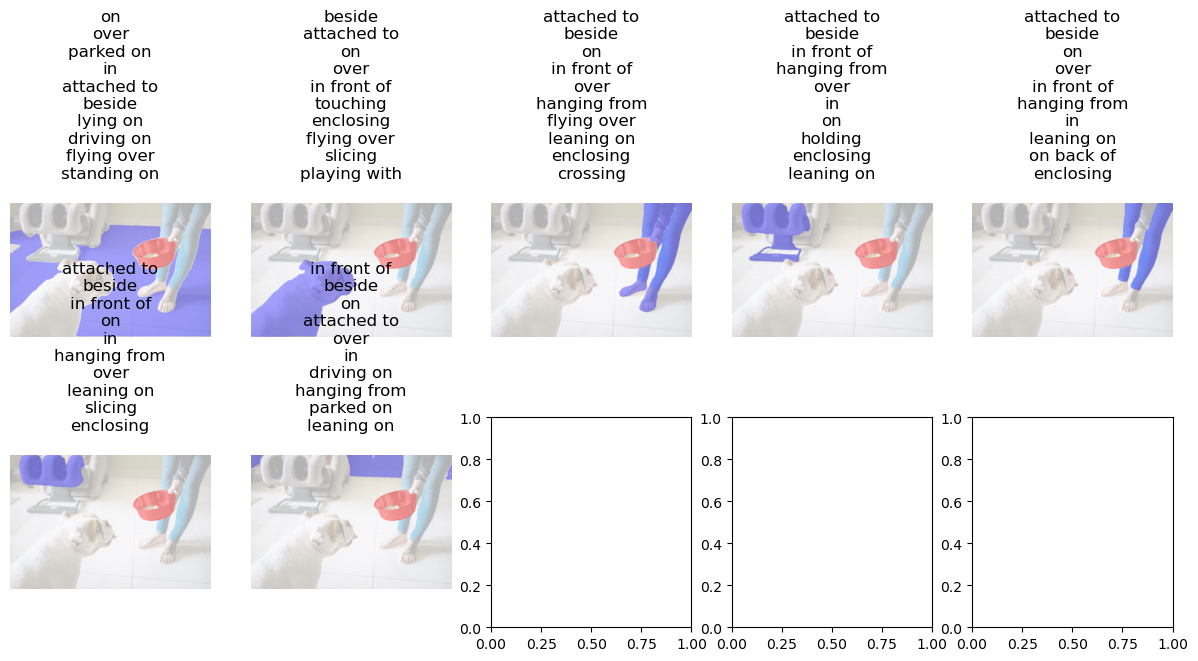

In [111]:
import math

model.load_state_dict(torch.load("best_model_bce.pth"))

# Calculate the number of rows needed
num_rows = math.ceil(len(filtered_masks) / 5)

# Create the subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

# Loop through the images and add them to the subplots
for i, mask in enumerate(filtered_masks):
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(image, alpha=0.3)
    axs[row, col].imshow(show_mask(mask1[0]))
    axs[row, col].imshow(show_anns(filtered_masks[i:i+1], 'blue'))
    axs[row, col].axis('off')
    
    # compute relations
    feat2 = torch.Tensor(filtered_masks[i]['feat']).unsqueeze(0).unsqueeze(0)
    concat_input = torch.cat((feat1, feat2), dim=2)
    output = model(concat_input)
    topk_indices = torch.argsort(-output).flatten()
    strings = [relation_classes[indice] + '\n' for indice in topk_indices[:k]]
    result = ''.join(strings)
    
    axs[row, col].set_title(result)
    

# Display the subplots
plt.show()